In [203]:
import torch
from torch import nn
from torch import Tensor, BoolTensor
import math
from typing import Tuple
import pandas as pd
import numpy as np
from torch.utils.data import TensorDataset, DataLoader
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from torch.optim.lr_scheduler import ExponentialLR

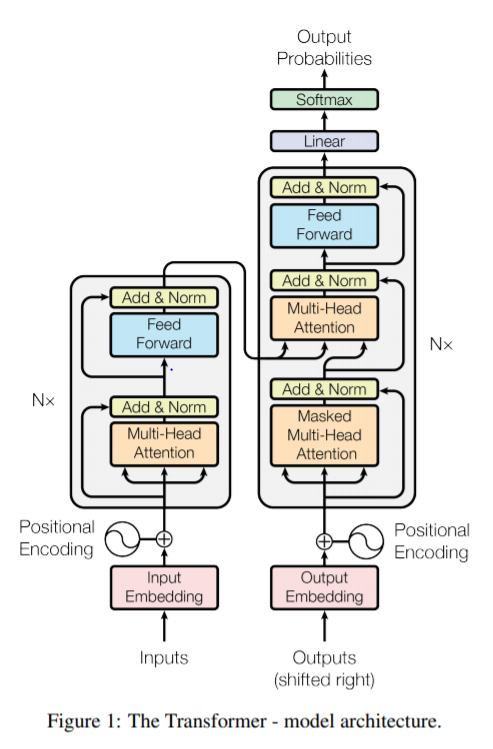

# BERT

## Model and Classes Definition

In [2]:
class FullyConnected(nn.Module):
  def __init__(self,
               input_dim: int,
               num_neurons:int,
               num_layers:int,
               target_dim: int,
               activation_function: nn.Module,
               final_activation_function: nn.Module = None,
               dropout: float = 0.1,
               ):
    # Creating the Fully Connected Part

    super(FullyConnected,self).__init__()
    self.input_dim = input_dim
    self.num_neurons = num_neurons
    self.num_layers = num_layers
    self.target_dim = target_dim
    self.activation_function = activation_function
    self.final_activation_function = final_activation_function
    self.dropout = dropout

    self.fc = []

    self.fc.append(nn.Linear(self.input_dim,self.num_neurons))
    self.fc.append(self.activation_function())
    self.fc.append(nn.Dropout(dropout))

    for _ in range(self.num_layers):
      self.fc.append(nn.Linear(self.num_neurons,self.num_neurons))
      self.fc.append(self.activation_function())
      self.fc.append(nn.Dropout(dropout))

    self.fc.append(nn.Linear(self.num_neurons,self.target_dim))

    self.fc =  nn.ModuleList(self.fc)

  def forward(self,x:Tensor)->Tensor:
    for layer in self.fc:
      x = layer(x)
    if self.final_activation_function != None:
      x = self.final_activation_function(x)
    return x

In [3]:
class EncoderTransformerBlock(nn.Module):
  def __init__(self,
               src_dim,
               enc_embed_dim,
               enc_num_heads,
               enc_dropout,
               enc_num_layers,
               enc_num_neurons,
               activation_function):
    super(EncoderTransformerBlock,self).__init__()

    # src_dim -> L
    # enc_embed_dim -> E
    self.enc_embed_dim = enc_embed_dim
    self.enc_num_heads = enc_num_heads
    self.enc_dropout = enc_dropout
    self.enc_num_layers = enc_num_layers
    self.enc_num_neurons = enc_num_neurons

    # Defining the Multihead Attention
    self.activation_function = activation_function
    self.enc_mha = nn.MultiheadAttention(enc_embed_dim,
                                         enc_num_heads,
                                         enc_dropout,
                                         batch_first=True)                                     
    # Norm Layers
    self.first_norm_layer = nn.LayerNorm(enc_embed_dim)
    self.second_norm_layer = nn.LayerNorm(enc_embed_dim)

    #Fully Connected Layer
    self.fc = FullyConnected(self.enc_embed_dim,
                             self.enc_num_neurons,
                             self.enc_num_layers,
                             self.enc_embed_dim,
                             self.activation_function)


  def forward(self,src: Tensor,src_mask: BoolTensor) -> Tensor:
    
    x = src

    query = x
    key =  x
    value = x

    attn_output,_ = self.enc_mha(query,key,value,src_mask)
    x = attn_output + x
    x = self.first_norm_layer(x)
    x = self.fc(x)
    x = self.second_norm_layer(x)
    return x

In [4]:
class PositionalEncoding(nn.Module):

    def __init__(self, d_model: int, dropout: float = 0.1, max_len: int = 5000):
        super().__init__()
        self.dropout = nn.Dropout(p=dropout)

        position = torch.arange(max_len).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2) * (-math.log(10000.0) / d_model))
        pe = torch.zeros(max_len, 1, d_model)
        pe[:, 0, 0::2] = torch.sin(position * div_term)
        pe[:, 0, 1::2] = torch.cos(position * div_term)
        self.register_buffer('pe', pe)

    def forward(self, x: Tensor) -> Tensor:
        """
        Args:
            x: Tensor, shape [batch_size, seq_len, embedding_dim]
        """
        x = x.transpose(0,1)
        x = x + self.pe[:x.size(0)]
        x = self.dropout(x)
        x = x.transpose(1,0)
        return self.dropout(x)

In [416]:
class Interpreter(nn.Module):
  def __init__( self,
                enc_embed_dim: int,
                num_building: int,
                num_neurons_building: int,
                num_layers_building: int,
                activation_function_building: nn.Module,
                num_floors: int,
                num_neurons_floor: int,
                num_layers_floor: int,
                activation_function_floor: nn.Module,
                num_positions: int,
                num_neurons_pos: int,
                num_layers_pos: int,
                activation_function_pos: nn.Module,
                dropout: float = 0.1
               ):
    super(Interpreter,self).__init__()

    self.building_interpreter = FullyConnected( enc_embed_dim,
                                                num_neurons_building,
                                                num_layers_building,
                                                target_dim = num_building,
                                                activation_function = activation_function_building,
                                                final_activation_function = nn.Softmax(dim=1),
                                                dropout = dropout
                                               )
  
    self.floor_interpreter = FullyConnected(  enc_embed_dim+num_building,
                                              num_neurons_building,
                                              num_layers_building,
                                              target_dim = num_floors,
                                              activation_function = activation_function_building,
                                              final_activation_function = nn.Softmax(dim=1),
                                              dropout = dropout
                                            )
    
    self.position_interpreter = FullyConnected( enc_embed_dim+num_building+num_floors,
                                                num_neurons_building,
                                                num_layers_building,
                                                target_dim = num_positions,
                                                activation_function = activation_function_building,
                                                final_activation_function = None,
                                                dropout = dropout
                                               )
    
  def forward(self,phrase: Tensor)-> Tuple[Tensor,Tensor,Tensor]:
    word =  phrase[:,0,:]
    building = self.building_interpreter(word)

    word =  phrase[:,1,:]
    floor = torch.cat((word, building), 1)
    floor = self.floor_interpreter(floor)

    word =  phrase[:,2,:]
    position = torch.cat((word, building,floor), 1)
    position = self.position_interpreter(position)

    return building,floor,position

In [375]:
class lockinBERT(nn.Module):
  def __init__( self,
                padding_idx: int,
                num_embed: int,
                src_dim: int,
                enc_embed_dim: int,
                enc_num_heads: int,
                enc_dropout: float,
                enc_num_layers: int,
                enc_num_neurons: int,
                enc_activation_function: nn.Module,
                enc_num_blocks: int,
                interpreter_dropout: float,
                num_building: int,
                num_neurons_building: int,
                num_layers_building: int,
                activation_function_building: nn.Module,
                num_floors: int,
                num_neurons_floor: int,
                num_layers_floor: int,
                activation_function_floor: nn.Module,
                num_positions: int,
                num_neurons_pos: int,
                num_layers_pos: int,
                activation_function_pos: nn.Module,
               ):
    '''
    num_embed: Number of Words in vocab
    src_dim: Dimension of documents (L, in pytorch documentation)
    enc_embed_dim: Number of the Embedding Vector (E, in pytorch documentation)

    '''

    super(lockinBERT,self).__init__()

    self.embedding =  nn.Embedding(num_embed,enc_embed_dim,padding_idx=padding_idx)
    self.pos_enc = PositionalEncoding(enc_embed_dim,enc_dropout,src_dim)
    self.encoder_blocks = nn.ModuleList([EncoderTransformerBlock(src_dim,
                                            enc_embed_dim,
                                            enc_num_heads,
                                            enc_dropout,
                                            enc_num_layers,
                                            enc_num_neurons,
                                            enc_activation_function) for _ in range(enc_num_blocks)])
    
    
    self.interpreter = Interpreter( enc_embed_dim,
                                    num_building,
                                    num_neurons_building,
                                    num_layers_building,
                                    activation_function_building,
                                    num_floors,
                                    num_neurons_floor,
                                    num_layers_floor,
                                    activation_function_floor,
                                    num_positions,
                                    num_neurons_pos,
                                    num_layers_pos,
                                    activation_function_pos,
                                    interpreter_dropout)

  def forward(self,src,src_mask) -> Tuple[Tensor,Tensor,Tensor]:
    x = src
    x = self.embedding(x)
    x = self.pos_enc(x)
    for block in self.encoder_blocks:
      phrase = block(x,src_mask)
    building,floor,position = self.interpreter(phrase)
    return building,floor,position
            



## Constants

In [585]:
padding_idx = 0
num_building = 3
num_floors = 5
num_positions = 2
num_embed = 521
src_dim = 15 #Max Len possible of one sequence (Min 3)

## Hyperparameters

Transformer-BERT Hyperparameters:

In [650]:
enc_embed_dim = 32
enc_num_heads = 16
enc_dropout = 0.1
enc_num_layers = 1
enc_num_neurons = 20
enc_activation_function = nn.ReLU
enc_num_blocks = 2

Interpret Hyperparameters:

In [651]:
interpreter_dropout = 0.1
num_neurons_building = 20
num_layers_building = 2
activation_function_building = nn.ReLU
num_neurons_floor = 16
num_layers_floor = 2
activation_function_floor = nn.ReLU
num_neurons_pos = 10
num_layers_pos = 8
activation_function_pos = nn.ReLU

## Create Model

In [652]:
lockin_bert = lockinBERT( padding_idx,
                          num_embed,
                          src_dim,
                          enc_embed_dim,
                          enc_num_heads,
                          enc_dropout,
                          enc_num_layers,
                          enc_num_neurons,
                          enc_activation_function,
                          enc_num_blocks,
                          interpreter_dropout,
                          num_building,
                          num_neurons_building,
                          num_layers_building,
                          activation_function_building,
                          num_floors,
                          num_neurons_floor,
                          num_layers_floor,
                          activation_function_floor,
                          num_positions,
                          num_neurons_pos,
                          num_layers_pos,
                          activation_function_pos
                         )

# Training Model

In [653]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [682]:
processed_data = pd.read_csv('/content/drive/MyDrive/Localisation/generated_data/processed_training_data.csv')

In [683]:
processed_data

,WAP001,WAP002,WAP003,WAP004,WAP005,WAP006,WAP007,WAP008,WAP009,WAP010,...,LONGITUDE,LATITUDE,FLOOR,BUILDINGID,SPACEID,RELATIVEPOSITION,USERID,PHONEID,TIMESTAMP,z
0,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,...,-7541.2643,4.864921e+06,2,1,106,2,2,23,1371713733,9.76
1,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,...,-7536.6212,4.864934e+06,2,1,106,2,2,23,1371713691,9.76
2,-999,-999,-999,-999,-999,-999,-999,-97,-999,-999,...,-7519.1524,4.864950e+06,2,1,103,2,2,23,1371714095,9.76
3,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,...,-7524.5704,4.864934e+06,2,1,102,2,2,23,1371713807,9.76
4,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,...,-7632.1436,4.864982e+06,0,0,122,2,11,13,1369909710,1.76
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19932,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,...,-7485.4686,4.864875e+06,3,1,1,2,18,10,1371710683,13.62
19933,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,...,-7390.6206,4.864836e+06,1,2,140,2,18,10,1371710402,5.62
19934,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,...,-7516.8415,4.864889e+06,3,1,13,2,18,10,1371710921,13.62
19935,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,...,-7537.3219,4.864896e+06,3,1,113,2,18,10,1371711049,13.62


In [380]:
def get_ranking(rss):
  # strongest to weakest AP
  ix = np.argsort(rss)[::-1]
  # index of first -999
  first_null = int(np.argwhere(rss[ix] == -999)[0])
  # remove all after first -999
  return ix[:first_null]

def assert_get_ranking(x, y):
  output = get_ranking(np.array(x))
  assert( np.array_equal(output, np.array(y)) )

In [83]:
rss = processed_data.iloc[:, 0:520]
# +1 makes 0 available as padding (in the input, for the training) and stop condition in the prediction
X = rss.apply(lambda r : get_ranking(r.to_numpy()), axis=1).to_numpy() + 1

In [84]:
discart_index = [i for i,x in enumerate(X) if len(x)==0]

In [85]:
len(discart_index)

76

In [86]:
X = pd.Series(X).drop(index=discart_index).tolist()

In [87]:
X

[array([173, 172,  90, 103, 104,  91, 105, 106, 192, 169, 168, 191, 167,
        171, 166, 125, 126]),
 array([ 90,  91, 173, 172, 105, 106, 169, 168, 192, 120, 119, 135, 104,
        183, 103, 182]),
 array([173, 172,  90,  91, 248, 192, 191, 104, 103, 168, 105, 106, 167,
          8, 126]),
 array([172, 173, 104, 103,  91,  90, 192, 191, 106, 223, 222, 105, 168,
        125, 126,  35]),
 array([172, 173,  90,  91, 192, 191, 104, 103, 105, 106, 168, 169,  46,
        126,  45]),
 array([ 90,  91, 172, 173, 191, 248, 192, 103, 104, 169, 168, 106, 105,
        167, 166, 126, 183]),
 array([173, 172,  91,  90, 192, 191, 103, 104, 168, 169, 105, 106, 126,
        125, 170,  36]),
 array([167, 166, 170, 171, 182, 183, 120, 119, 184, 185, 123, 124, 137,
        136,  91, 173, 103]),
 array([248, 172, 173, 192, 191,  90,  91, 223, 222, 168, 454]),
 array([248, 150,   8, 172, 173, 192, 151, 104, 191, 103,  90,  91, 156,
        142,  36, 155, 268]),
 array([172, 173,  91,  90, 192, 191, 103, 

In [88]:
len_x = pd.Series(X).apply(lambda phrase: len(phrase))

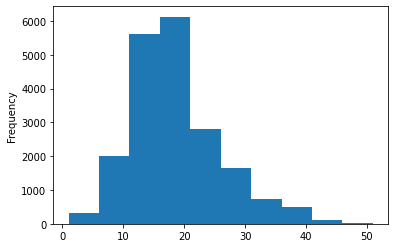

In [89]:
len_x.plot.hist()

In [90]:
len_x.quantile(0.95)

33.0

In [91]:
y = processed_data[['BUILDINGID', 'FLOOR', 'SPACEID']].to_numpy()

In [624]:
transform_constantes = {}

for b in [0,1,2]:
  transform_constantes[b]={}
  max = processed_data[processed_data['BUILDINGID']==b]['LONGITUDE'].max()
  min = processed_data[processed_data['BUILDINGID']==b]['LONGITUDE'].min()
  transform_constantes[b]['x_sum'] = (max+min)
  transform_constantes[b]['x_diff'] = (max-min)
  max = processed_data[processed_data['BUILDINGID']==b]['LATITUDE'].max()
  min = processed_data[processed_data['BUILDINGID']==b]['LATITUDE'].min()
  transform_constantes[b]['y_sum'] = (max+min)
  transform_constantes[b]['y_diff'] = (max-min)

In [93]:
transform_constantes

{0: {'x_sum': -15278.379799999297,
  'x_diff': 104.29699999839067,
  'y_sum': 9729914.2139,
  'y_diff': 119.16169999539852},
 1: {'x_sum': -14982.953654557467,
  'x_diff': 173.97028854489326,
  'y_sum': 9729769.535351187,
  'y_diff': 149.475151181221},
 2: {'x_sum': -14715.981993623078,
  'x_diff': 114.34401343762875,
  'y_sum': 9729607.501118824,
  'y_diff': 116.01108688116074}}

In [625]:
def convert_x(serie):
  b = serie['BUILDINGID']
  x_sum=transform_constantes[b]['x_sum']
  x_diff=transform_constantes[b]['x_diff']
  x = (2*serie['LONGITUDE'] - x_sum)/x_diff
  return x

def convert_y(serie):
  b = serie['BUILDINGID']
  y_sum=transform_constantes[b]['y_sum']
  y_diff=transform_constantes[b]['y_diff']
  y = (2*serie['LATITUDE'] - y_sum)/y_diff
  return y



In [626]:
processed_data['LATITUDE'] = processed_data.apply(convert_y,axis='columns')
processed_data['LONGITUDE'] = processed_data.apply(convert_x,axis='columns')

In [627]:
output_data = processed_data[['BUILDINGID','FLOOR','LONGITUDE','LATITUDE']]
output_data

,BUILDINGID,FLOOR,LONGITUDE,LATITUDE
0,1,2,-0.572368,0.481826
1,1,2,-0.518989,0.661749
2,1,2,-0.318164,0.866559
3,1,2,-0.380451,0.659980
4,0,0,0.135120,0.421447
...,...,...,...,...
19932,1,3,0.069072,-0.134490
19933,2,1,-0.570727,0.556934
19934,1,3,-0.291598,0.060523
19935,1,3,-0.527045,0.147289


In [684]:
target = []
for i,row in output_data.iterrows():

  b = int(row['BUILDINGID'])
  f = int(row['FLOOR'])
  x = float(row['LONGITUDE'])
  y = float(row['LATITUDE'])

  building = np.zeros(3)
  floor = np.zeros(5)
  position = np.zeros(2)

  building[b] = 1
  floor[f] = 1
  position[0] = x
  position[1] = y

  target.append([*building,*floor,*position])




In [685]:
rss = processed_data.iloc[:, 0:520]
# +1 makes 0 available as padding (in the input, for the training) and stop condition in the prediction
X = rss.apply(lambda r : get_ranking(r.to_numpy()), axis=1).to_numpy() + 1

In [686]:
discart_index = [i for i,x in enumerate(X) if len(x)==0]

In [687]:
X = pd.Series(X).drop(index=discart_index).tolist()
X = [x.tolist() for x in X]

In [688]:
X

[[173,
  172,
  90,
  103,
  104,
  91,
  105,
  106,
  192,
  169,
  168,
  191,
  167,
  171,
  166,
  125,
  126],
 [90,
  91,
  173,
  172,
  105,
  106,
  169,
  168,
  192,
  120,
  119,
  135,
  104,
  183,
  103,
  182],
 [173, 172, 90, 91, 248, 192, 191, 104, 103, 168, 105, 106, 167, 8, 126],
 [172, 173, 104, 103, 91, 90, 192, 191, 106, 223, 222, 105, 168, 125, 126, 35],
 [172, 173, 90, 91, 192, 191, 104, 103, 105, 106, 168, 169, 46, 126, 45],
 [90,
  91,
  172,
  173,
  191,
  248,
  192,
  103,
  104,
  169,
  168,
  106,
  105,
  167,
  166,
  126,
  183],
 [173, 172, 91, 90, 192, 191, 103, 104, 168, 169, 105, 106, 126, 125, 170, 36],
 [167,
  166,
  170,
  171,
  182,
  183,
  120,
  119,
  184,
  185,
  123,
  124,
  137,
  136,
  91,
  173,
  103],
 [248, 172, 173, 192, 191, 90, 91, 223, 222, 168, 454],
 [248,
  150,
  8,
  172,
  173,
  192,
  151,
  104,
  191,
  103,
  90,
  91,
  156,
  142,
  36,
  155,
  268],
 [172,
  173,
  91,
  90,
  192,
  191,
  103,
  104,
 

In [689]:
target = pd.Series(target)
target = pd.Series(target).drop(index=discart_index).tolist()
target

[[0.0,
  1.0,
  0.0,
  0.0,
  0.0,
  1.0,
  0.0,
  0.0,
  -0.572367536291585,
  0.48182623161719546],
 [0.0,
  1.0,
  0.0,
  0.0,
  0.0,
  1.0,
  0.0,
  0.0,
  -0.5189894561636228,
  0.6617491136566008],
 [0.0,
  1.0,
  0.0,
  0.0,
  0.0,
  1.0,
  0.0,
  0.0,
  -0.3181643595685966,
  0.8665590754835959],
 [0.0,
  1.0,
  0.0,
  0.0,
  0.0,
  1.0,
  0.0,
  0.0,
  -0.3804508574157423,
  0.6599802578411024],
 [0.0,
  1.0,
  0.0,
  0.0,
  0.0,
  1.0,
  0.0,
  0.0,
  -0.4876622678194863,
  0.7290927485248729],
 [0.0,
  1.0,
  0.0,
  0.0,
  0.0,
  1.0,
  0.0,
  0.0,
  -0.3181643595685966,
  0.8665590754835959],
 [0.0,
  1.0,
  0.0,
  0.0,
  0.0,
  1.0,
  0.0,
  0.0,
  -0.4135680065993857,
  0.5937940059331386],
 [0.0,
  1.0,
  0.0,
  0.0,
  0.0,
  1.0,
  0.0,
  0.0,
  -0.7819780410689221,
  0.03857128601716627],
 [0.0,
  1.0,
  0.0,
  0.0,
  0.0,
  1.0,
  0.0,
  0.0,
  -0.21797223074570027,
  0.8628021527655049],
 [0.0,
  1.0,
  0.0,
  0.0,
  0.0,
  1.0,
  0.0,
  0.0,
  -0.42926380800150093,


In [690]:
class BERTPreprocessing:

  def __init__(self, src_dim: int ,padding_idx: int = 0):
    self.src_dim = src_dim
    self.padding_idx = padding_idx

  def pre_padding(self,phrase: list) -> list:
    if len(phrase) < self.src_dim:
      while len(phrase) < self.src_dim:
        phrase.append(self.padding_idx)
    else:
      phrase = phrase[:self.src_dim]

    return phrase

  def preprocess(self,X: list) -> Tuple[torch.IntTensor,torch.BoolTensor]:
    input_ids = [self.pre_padding(phrase) for phrase in X]
    attention_masks = [np.where(np.array(phrase)==self.padding_idx,1,0) for phrase in input_ids]

    input_ids = np.array(input_ids)
    input_ids = input_ids.astype(np.int32)
    input_ids = torch.IntTensor(input_ids)

    attention_masks = np.array(attention_masks)
    attention_masks = attention_masks.astype(np.float32)
    attention_masks = torch.BoolTensor(attention_masks)

    return input_ids,attention_masks

In [691]:
preprocess = BERTPreprocessing(src_dim=src_dim,padding_idx=padding_idx)

In [692]:
input_ids,attention_masks = preprocess.preprocess(X[:10].copy())

In [693]:
lockin_bert.eval()
output = lockin_bert(input_ids,attention_masks)

RuntimeError: ignored

In [694]:
n_building = 100000
n_floor = 10000
n_position =1

In [709]:
def r2_loss(output, target):
    target_mean = torch.mean(target)
    ss_tot = torch.sum((target - target_mean) ** 2)
    ss_res = torch.sum((target - output) ** 2)
    r2 = 1 - ss_res / ss_tot
    return r2

def custom_criterion(output,target,cross_entropy,mse,it):
  if it < 25:
    n_building = 100000
    n_floor = 10000
    n_position =1
  else:
    n_building = 1000
    n_floor = 100000
    n_position =1

  pred_building,pred_floor,pred_position = output

  pred_x = pred_position[:,0]
  pred_y = pred_position[:,1]
  building=target[:,:3]
  floor=target[:,3:8]
  pos_x = target[:,8]
  pos_y = target[:,9]


  lb = cross_entropy(pred_building,building)
  lf = cross_entropy(pred_floor,floor)
  lx = mse(pred_x,pos_x)
  ly = mse(pred_y,pos_y)

  l = n_building*lb + n_floor*lf + n_position*(lx+ly)

  return lx+ly



In [697]:
def get_loaders(X_train,X_test,y_train,y_test,batch_size,preprocess):

  X_train_inputs,X_train_mask = preprocess.preprocess(X_train)
  X_test_inputs,X_test_mask = preprocess.preprocess(X_test)
  y_train_tensor = torch.Tensor(y_train)
  y_test_tensor = torch.Tensor(y_test)

  train_data = TensorDataset(X_train_inputs,X_train_mask,y_train_tensor)
  test_data = TensorDataset(X_test_inputs,X_test_mask,y_test_tensor)

  train_loader = DataLoader(train_data,batch_size=batch_size)
  test_loader = DataLoader(test_data,batch_size=batch_size)

  return train_loader,test_loader

In [698]:
X_train, X_test, y_train, y_test = train_test_split(X, target, test_size=0.33, random_state=42)

In [699]:
train_loader,test_loader = get_loaders(X_train,X_test,y_train,y_test,batch_size=512,preprocess=preprocess)

In [700]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
lockin_bert.to(device)

lockinBERT(
  (embedding): Embedding(521, 32, padding_idx=0)
  (pos_enc): PositionalEncoding(
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder_blocks): ModuleList(
    (0): EncoderTransformerBlock(
      (enc_mha): MultiheadAttention(
        (out_proj): NonDynamicallyQuantizableLinear(in_features=32, out_features=32, bias=True)
      )
      (first_norm_layer): LayerNorm((32,), eps=1e-05, elementwise_affine=True)
      (second_norm_layer): LayerNorm((32,), eps=1e-05, elementwise_affine=True)
      (fc): FullyConnected(
        (fc): ModuleList(
          (0): Linear(in_features=32, out_features=20, bias=True)
          (1): ReLU()
          (2): Dropout(p=0.1, inplace=False)
          (3): Linear(in_features=20, out_features=20, bias=True)
          (4): ReLU()
          (5): Dropout(p=0.1, inplace=False)
          (6): Linear(in_features=20, out_features=32, bias=True)
        )
      )
    )
    (1): EncoderTransformerBlock(
      (enc_mha): MultiheadAttention(
        (o

In [701]:
class EarlyStopper:
    def __init__(self, patience=1, min_delta=0):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.min_validation_loss = np.inf

    def early_stop(self, validation_loss):
        if validation_loss < self.min_validation_loss:
            self.min_validation_loss = validation_loss
            self.counter = 0
        elif validation_loss > (self.min_validation_loss + self.min_delta):
            self.counter += 1
            if self.counter >= self.patience:
                return True
        return False

In [702]:
def accuracy(outputs,targets):
  pred_building,pred_floor,pred_position = outputs
  building=targets[:,:3]
  floor=targets[:,3:8]
  floor_acc = torch.sum(torch.argmax(floor,dim=1).to(device) == torch.argmax(pred_floor,dim=1).to(device))/building.size(0)
  building_acc = torch.sum(torch.argmax(building,dim=1).to(device) == torch.argmax(pred_building,dim=1).to(device))/floor.size(0)
  return building_acc,floor_acc

In [703]:
def train_model(model,train_loader,test_loader,n_epochs,optimizer,criterion,mean_loss_train,mean_loss_test,scheduler):

  cross_entropy = nn.CrossEntropyLoss()
  mse = nn.MSELoss()
  test_accuracy = {'Building':[],'Floor':[]}


  early_stopper = EarlyStopper(patience=10, min_delta=0)
  for it in range(n_epochs):
    train_loss = []
    for inputs,masks,targets in train_loader:
      inputs,masks,targets = inputs.to(device),masks.to(device),targets.to(device)
      optimizer.zero_grad()
      outputs = model(inputs,masks)
      loss = criterion(outputs,targets,cross_entropy,mse,it)
      loss.backward()
      optimizer.step()
      train_loss.append(loss.item())
    scheduler.step()
    mean_loss_train.append(np.mean(train_loss))
    test_loss = []
    test_accuracy['Building'].append([])
    test_accuracy['Floor'].append([])
    for inputs,masks,targets in test_loader:
      inputs,masks,targets = inputs.to(device),masks.to(device),targets.to(device)
      outputs = model(inputs,masks)
      loss = criterion(outputs,targets,cross_entropy,mse,it)
      test_loss.append(loss.item())
      building_acc,floor_acc = accuracy(outputs,targets)
      test_accuracy['Building'][-1].append(building_acc.item())
      test_accuracy['Floor'][-1].append(floor_acc.item())

    test_accuracy['Building'][-1] = np.mean(test_accuracy['Building'][-1])
    test_accuracy['Floor'][-1] = np.mean(test_accuracy['Floor'][-1])

    mean_acc_building = float(test_accuracy['Building'][-1])
    mean_acc_floor = float(test_accuracy['Floor'][-1])

    test_loss = np.mean(test_loss)
    mean_loss_test.append(test_loss)

    print(f'Epoch {it}/{n_epochs}, Train Loss: {mean_loss_train[-1]:.4f}, Test Loss:{mean_loss_test[-1]:.4f}/Test Acc-Building: {mean_acc_building:0.4f},Test Acc-Floor:{mean_acc_floor:0.4f}')

    if it==26:
      early_stopper = EarlyStopper(patience=10, min_delta=0)
    if early_stopper.early_stop(test_loss):
      break
  
  return mean_loss_train,mean_loss_test,test_accuracy

In [710]:
criterion = custom_criterion
optimizer = torch.optim.Adam(lockin_bert.parameters())
scheduler = ExponentialLR(optimizer, gamma=0.995)

In [711]:
mean_loss_train = []
mean_loss_test = []

In [712]:
mean_loss_train,mean_loss_test,test_accuracy = train_model(lockin_bert,
                                                            train_loader,
                                                            test_loader,
                                                            n_epochs=1000,
                                                            optimizer=optimizer,
                                                            criterion=criterion,
                                                            mean_loss_train=mean_loss_train,
                                                            mean_loss_test=mean_loss_test,
                                                            scheduler=scheduler)

Epoch 0/1000, Train Loss: 0.2434, Test Loss:0.2076/Test Acc-Building: 0.9955,Test Acc-Floor:0.8818
Epoch 1/1000, Train Loss: 0.1795, Test Loss:0.1768/Test Acc-Building: 0.9963,Test Acc-Floor:0.8765
Epoch 2/1000, Train Loss: 0.1514, Test Loss:0.1555/Test Acc-Building: 0.9966,Test Acc-Floor:0.8606
Epoch 3/1000, Train Loss: 0.1332, Test Loss:0.1411/Test Acc-Building: 0.9961,Test Acc-Floor:0.8557
Epoch 4/1000, Train Loss: 0.1200, Test Loss:0.1294/Test Acc-Building: 0.9961,Test Acc-Floor:0.8525
Epoch 5/1000, Train Loss: 0.1092, Test Loss:0.1208/Test Acc-Building: 0.9962,Test Acc-Floor:0.8525
Epoch 6/1000, Train Loss: 0.1013, Test Loss:0.1137/Test Acc-Building: 0.9957,Test Acc-Floor:0.8510
Epoch 7/1000, Train Loss: 0.0944, Test Loss:0.1069/Test Acc-Building: 0.9951,Test Acc-Floor:0.8473
Epoch 8/1000, Train Loss: 0.0890, Test Loss:0.1033/Test Acc-Building: 0.9962,Test Acc-Floor:0.8448
Epoch 9/1000, Train Loss: 0.0832, Test Loss:0.0978/Test Acc-Building: 0.9951,Test Acc-Floor:0.8480
Epoch 10/1

In [707]:
def plot_model_metrics(mean_loss_train,mean_loss_test):
  plt.plot(mean_loss_train,label='Train')
  plt.plot(mean_loss_test,label='Test')
  plt.title('Loss - Epochs')
  plt.xlabel('Epochs')
  plt.ylabel('Loss')
  plt.legend()
  plt.show()

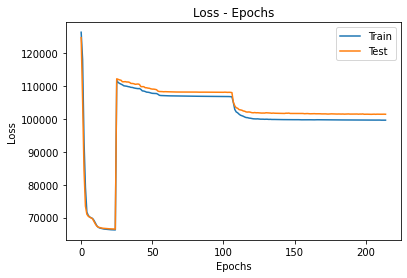

In [708]:
plot_model_metrics(mean_loss_train,mean_loss_test)

In [ ]:
bert

In [714]:
X_test_inputs,X_test_mask = preprocess.preprocess(X_test)

In [410]:
np.array(y_test)[:,:3]

array([[0., 1., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       ...,
       [0., 1., 0.],
       [0., 1., 0.],
       [1., 0., 0.]])

In [721]:
pred_building,pred_floor,pred_pos = lockin_bert(X_test_inputs.to(device),X_test_mask.to(device))
building = torch.Tensor(np.array(y_test)[:,:3])
floor = torch.Tensor(np.array(y_test)[:,3:8])
pos_x = torch.Tensor(np.array(y_test)[:,8])
pos_y = torch.Tensor(np.array(y_test)[:,9])

In [722]:
mse(pred_pos[:,1].to(device),pos_y.to(device))

tensor(0.0191, device='cuda:0', grad_fn=<MseLossBackward0>)

In [505]:
pred_floor

tensor([[9.9999e-01, 5.9360e-06, 4.7390e-09, 2.1783e-21, 1.0551e-14],
        [1.0000e+00, 4.6453e-06, 8.2868e-08, 1.7035e-18, 7.6226e-15],
        [2.3096e-08, 4.0001e-31, 9.9996e-01, 3.9765e-05, 1.6902e-24],
        ...,
        [5.0269e-05, 1.0429e-18, 9.9995e-01, 9.2223e-09, 3.2124e-17],
        [5.2430e-01, 2.6879e-12, 4.7570e-01, 2.9368e-09, 1.9103e-12],
        [3.3362e-04, 2.4244e-20, 9.9967e-01, 6.7319e-12, 3.8649e-19]],
       device='cuda:0', grad_fn=<SoftmaxBackward0>)

In [506]:
torch.argmax(pred_building,dim=1)

tensor([1, 0, 0,  ..., 1, 1, 0], device='cuda:0')

In [507]:
test_acc = torch.sum(torch.argmax(floor,dim=1).to(device) == torch.argmax(pred_floor,dim=1).to(device))

In [508]:
test_acc/pred_floor.size(0)

tensor(0.7904, device='cuda:0')

In [509]:
pred_building.size(0)

6555

In [510]:
test_acc = torch.sum(torch.argmax(pred_floor,dim=1).to(device) == torch.argmax(building,dim=1).to(device))